<div class="alert alert-block alert-info">
__Name__: pangenome_hyperopt<br/>
__Description__: Try automated search for classifier and optimum hyper-parameters<br/>
__Author__: Matthew Whiteside matthew dot whiteside at canada dot ca<br/>
__Date__: Oct 11, 2017<br/>
__TODO__:<br/>
</div>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Load external libs
from hpsklearn import HyperoptEstimator, any_classifier, xgboost_classification, random_forest, gradient_boosting, extra_trees
from hyperopt import tpe
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10.0,8.0]

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


/home/matt/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# Load data
import os
os.chdir('../pangenome')
import config
import utils
import classify
pg, genome_list, locus_list = utils.read_panseq(config.PANSEQ['pangenome_file'])
amr,amr_list = utils.read_amr(config.PHENOTYPE['amr_file'], genome_list)
annot = utils.read_annot(config.ANNOTATION['blast_file'])

In [4]:
# Split into train & test for ampicillin
d = np.argwhere(amr_list == 'ampicillin').item(0)
validrows = ~np.isnan(amr[:,d])
validrows
X = pg[validrows,:]
y = amr[validrows,d]

test_size = int( 0.2 * len( y ) )
np.random.seed( 21 )
indices = np.random.permutation(X.shape[0])
X_train = X[ indices[:-test_size] ]
y_train = y[ indices[:-test_size] ]
X_test = X[ indices[-test_size:] ]
y_test = y[ indices[-test_size:] ]

In [5]:
# Define loss function
def loss_fn(y_target, y_prediction):
    return 1.0 - f1_score(y_target, y_prediction)

In [6]:
# HP search for Random Forest
rfc = HyperoptEstimator( classifier=random_forest('rfc'), preprocessing=[], algo=tpe.suggest, loss_fn=loss_fn, trial_timeout=2000)
rfc.fit( X_train.toarray(), y_train )
print( rfc.score( X_test.toarray(), y_test ) )
print( rfc.best_model() )
predictions = rfc.predict( X_test.toarray() )
print(classification_report(y_test, predictions))

0.955882352941
{'learner': RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=4, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=355, n_jobs=1, oob_score=False, random_state=0,
            verbose=False, warm_start=False), 'preprocs': (), 'ex_preprocs': ()}
             precision    recall  f1-score   support

        0.0       0.88      0.93      0.90        15
        1.0       0.98      0.96      0.97        53

avg / total       0.96      0.96      0.96        68



In [7]:
predictions = rfc.predict( X_test.toarray() )
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

        0.0       0.88      0.93      0.90        15
        1.0       0.98      0.96      0.97        53

avg / total       0.96      0.96      0.96        68



In [8]:
etc = HyperoptEstimator( classifier=extra_trees('etc'), preprocessing=[], algo=tpe.suggest, loss_fn=loss_fn, trial_timeout=2000)
etc.fit( X_train.toarray(), y_train )
print( etc.score( X_test.toarray(), y_test ) )
print( etc.best_model() )
predictions = etc.predict( X_test.toarray() )
print(classification_report(y_test, predictions))

0.941176470588
{'learner': ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='gini',
           max_depth=None, max_features=0.5891940414842171,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=274, n_jobs=1,
           oob_score=False, random_state=2, verbose=False,
           warm_start=False), 'preprocs': (), 'ex_preprocs': ()}
             precision    recall  f1-score   support

        0.0       0.82      0.93      0.87        15
        1.0       0.98      0.94      0.96        53

avg / total       0.95      0.94      0.94        68



In [9]:
gbc = HyperoptEstimator( classifier=gradient_boosting('gbc'), preprocessing=[], algo=tpe.suggest, loss_fn=loss_fn, trial_timeout=2000)
gbc.fit( X_train.toarray(), y_train )
print( gbc.score( X_test.toarray(), y_test ) )
print( gbc.best_model() )
predictions = gbc.predict( X_test.toarray() )
print(classification_report(y_test, predictions))

0.955882352941
{'learner': GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.0049733145749394445, loss='deviance',
              max_depth=None, max_features=0.5493645062981941,
              max_leaf_nodes=None, min_impurity_split=1e-07,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=346,
              presort='auto', random_state=1, subsample=1.0, verbose=0,
              warm_start=False), 'preprocs': (), 'ex_preprocs': ()}
             precision    recall  f1-score   support

        0.0       0.88      0.93      0.90        15
        1.0       0.98      0.96      0.97        53

avg / total       0.96      0.96      0.96        68



In [10]:
xbc = HyperoptEstimator( classifier=xgboost_classification('xbc'), preprocessing=[], algo=tpe.suggest, loss_fn=loss_fn, trial_timeout=2000)
xbc.fit( X_train.toarray(), y_train )
print( xbc.score( X_test.toarray(), y_test ) )
print( xbc.best_model() )
predictions = xbc.predict( X_test.toarray() )
print(classification_report(y_test, predictions))

/home/matt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/matt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/matt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/matt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/matt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cla

0.911764705882
{'learner': XGBClassifier(base_score=0.5, colsample_bylevel=0.7262105351712158,
       colsample_bytree=0.5091413208581086, gamma=0.035000114235359474,
       learning_rate=0.0007454683115566495, max_delta_step=0, max_depth=9,
       min_child_weight=2, missing=nan, n_estimators=3200, nthread=-1,
       objective='binary:logistic', reg_alpha=0.025476603344027546,
       reg_lambda=1.0548842656907973, scale_pos_weight=1, seed=2,
       silent=True, subsample=0.664142453517063), 'preprocs': (), 'ex_preprocs': ()}
             precision    recall  f1-score   support

        0.0       0.80      0.80      0.80        15
        1.0       0.94      0.94      0.94        53

avg / total       0.91      0.91      0.91        68



In [11]:
# Examine feature importance
rfcb = rfc._best_learner
etcb = etc._best_learner
gbcb = gbc._best_learner
xbcb = xbc._best_learner

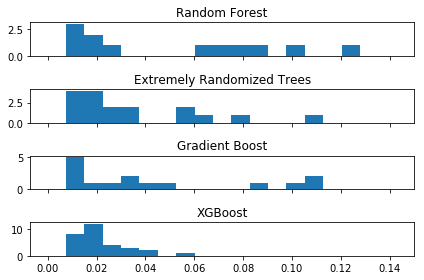

In [12]:
# Distributions
classify.histplot([rfcb.feature_importances_, etcb.feature_importances_, gbcb.feature_importances_, xbcb.feature_importances_], 
                  ['Random Forest','Extremely Randomized Trees', 'Gradient Boost', 'XGBoost'])

In [13]:
# Correlation between classifiers
importances = pd.DataFrame({'randomforest': rfcb.feature_importances_, 'extratrees': etcb.feature_importances_, 'gradientboost': gbcb.feature_importances_, 'xgboost': xbcb.feature_importances_},
            index=locus_list)

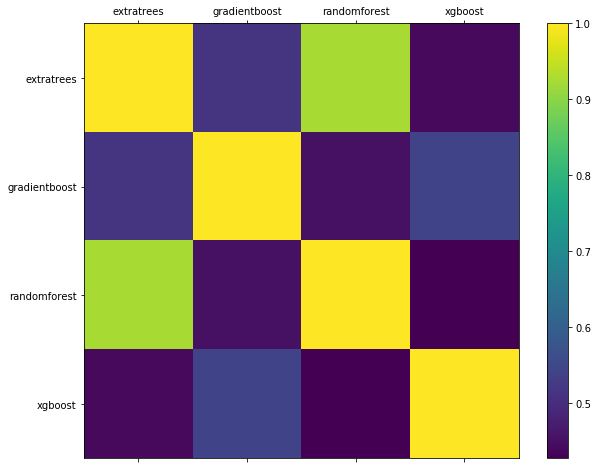

In [118]:
classify.corrplot(importances)

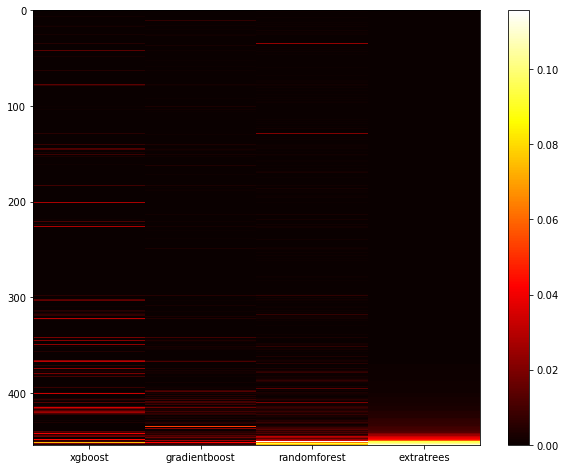

In [119]:
classify.heatplot(importances)

In [14]:
# Identify problematic features that result in FP/FN
test_genomes = genome_list[ indices[-test_size:] ]
xbpred = xbc.predict( X_test.toarray() )
xbfp = test_genomes[(y_test != xbpred) & (y_test == 0)]
xbfn = test_genomes[(y_test != xbpred) & (y_test == 1)]
confusion_matrix(y_test, xbpred)

array([[12,  3],
       [ 3, 50]])

In [15]:
gbpred = gbc.predict( X_test.toarray() )
gbfp = test_genomes[(y_test != gbpred) & (y_test == 0)]
gbfn = test_genomes[(y_test != gbpred) & (y_test == 1)]
confusion_matrix(y_test, gbpred)

array([[14,  1],
       [ 2, 51]])

In [16]:
etpred = etc.predict( X_test.toarray() )
etfp = test_genomes[(y_test != etpred) & (y_test == 0)]
etfn = test_genomes[(y_test != etpred) & (y_test == 1)]
confusion_matrix(y_test, etpred)

array([[14,  1],
       [ 3, 50]])

In [17]:
rfpred = rfc.predict( X_test.toarray() )
rffp = test_genomes[(y_test != rfpred) & (y_test == 0)]
rffn = test_genomes[(y_test != rfpred) & (y_test == 1)]
confusion_matrix(y_test, rfpred)

array([[14,  1],
       [ 2, 51]])

In [18]:
np.unique(np.concatenate((rffp,etfp,xbfp,gbfp)),return_counts=True)

(array(['85569_dot_218', '85569_dot_355', '85569_dot_38'], dtype=object),
 array([4, 1, 1]))

In [19]:
np.unique(np.concatenate((rffn,etfn,xbfn,gbfn)),return_counts=True)

(array(['85569_dot_216', '85569_dot_345', '85569_dot_44'], dtype=object),
 array([4, 4, 2]))

In [20]:
classify.bad_features('85569_dot_218', importances['randomforest'], X, y, locus_list, genome_list)

/home/matt/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:213: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  ", try using != instead.", SparseEfficiencyWarning)


,feature,importance,oddsratio,pvalue,resistant_with,resistant_without,susceptible_with,susceptible_without
0,22599464615000,0.068759,1.632994,0.110276,64,214,21,43
1,28625988412000,0.028710,2.893923,0.002598,181,97,54,10
2,28625988224000,0.017786,0.054152,0.004867,277,1,60,4
3,27119357311000,0.010655,0.000000,0.187135,278,0,63,1
4,30132619347000,0.010363,0.000000,0.006305,278,0,61,3
5,18079571711000,0.010193,0.000000,0.187135,278,0,63,1
6,7533154937000,0.009838,0.000000,0.187135,278,0,63,1
7,1506631131000,0.008612,0.000000,0.187135,278,0,63,1
8,9039785910000,0.008531,0.000000,0.034573,278,0,62,2
9,10546416923000,0.003181,0.000000,0.187135,278,0,63,1


In [21]:
classify.bad_features('85569_dot_218', importances['extratrees'], X, y, locus_list, genome_list)

/home/matt/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:213: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  ", try using != instead.", SparseEfficiencyWarning)


,feature,importance,oddsratio,pvalue,resistant_with,resistant_without,susceptible_with,susceptible_without
0,30132619115000,0.055336,0.027834,7.560859e-21,270,8,31,33
1,16572940550000,0.025149,0.032924,1.645657e-20,268,10,30,34
2,22599464615000,0.016718,1.632994,1.102762e-01,64,214,21,43
3,24106095314000,0.016467,0.029630,5.753263e-20,270,8,32,32
4,12053047863000,0.014303,0.497095,2.189518e-02,204,74,37,27
5,28625988412000,0.013871,2.893923,2.598339e-03,181,97,54,10
6,25612726489000,0.011822,0.449011,9.229767e-03,219,59,40,24
7,27119357311000,0.008166,0.000000,1.871345e-01,278,0,63,1
8,18079571711000,0.007910,0.000000,1.871345e-01,278,0,63,1
9,7533154937000,0.007729,0.000000,1.871345e-01,278,0,63,1


In [270]:
classify.bad_features('85569_dot_218', importances['gradientboost'], X, y, locus_list, genome_list)

/home/matt/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:213: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  ", try using != instead.", SparseEfficiencyWarning)


,feature,importance,oddsratio,pvalue,resistant_with,resistant_without,susceptible_with,susceptible_without
0,15066309717000,0.019633,0.766734,3.962171e-01,170,108,35,29
1,30132619115000,0.010115,0.027834,7.560859e-21,270,8,31,33
2,30132619264000,0.009614,0.328930,1.081597e-04,199,79,29,35
3,12053047863000,0.008266,0.497095,2.189518e-02,204,74,37,27
4,19586202459000,0.007229,0.208042,2.603803e-04,264,14,51,13
5,10546416756000,0.006033,0.134552,3.252811e-11,237,41,28,36
6,28625988412000,0.004941,2.893923,2.598339e-03,181,97,54,10
7,25612726489000,0.004849,0.449011,9.229767e-03,219,59,40,24
8,16572940550000,0.004540,0.032924,1.645657e-20,268,10,30,34
9,12053047721000,0.004291,0.370684,1.236340e-02,254,24,51,13


In [22]:
classify.bad_features('85569_dot_218', importances['xgboost'], X, y, locus_list, genome_list)

/home/matt/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:213: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  ", try using != instead.", SparseEfficiencyWarning)


,feature,importance,oddsratio,pvalue,resistant_with,resistant_without,susceptible_with,susceptible_without
0,12053047863000,0.041947,0.497095,2.189518e-02,204,74,37,27
1,30132619115000,0.030501,0.027834,7.560859e-21,270,8,31,33
2,30132619271000,0.027067,0.395463,4.426639e-03,233,45,43,21
3,22599464615000,0.025922,1.632994,1.102762e-01,64,214,21,43
4,28625988412000,0.024778,2.893923,2.598339e-03,181,97,54,10
5,16572940550000,0.021075,0.032924,1.645657e-20,268,10,30,34
6,25612726489000,0.020132,0.449011,9.229767e-03,219,59,40,24
7,12053047721000,0.018920,0.370684,1.236340e-02,254,24,51,13
8,30132619264000,0.015351,0.328930,1.081597e-04,199,79,29,35
9,22599464359000,0.015149,0.676008,2.088221e-01,209,69,43,21


In [87]:
# Use approach in http://blog.datadive.net/random-forest-interpretation-with-scikit-learn/
# Treats each decision for given prediction as sum of weighted feature contributions.
# Identifies which features produced prediction
from treeinterpreter import treeinterpreter as ti

# False positive
genomefp = '85569_dot_218'
genomefp_features = X[np.isin(genome_list, genomefp),:]
print(rfcb.predict_proba(genomefp_features))

[[ 0.24128984  0.75871016]]


In [88]:
predictionfp, biasfp, contributionsfp = ti.predict(rfcb, genomefp_features)
print("Prediction", predictionfp)
print("Bias (trainset prior)", biasfp)
print("Feature contributions:")

Prediction [[ 0.24128984  0.75871016]]
Bias (trainset prior) [[ 0.17883212  0.82116788]]
Feature contributions:


In [89]:
contributing_features_fp = (np.absolute(contributionsfp[0])[:,1].argsort()[::-1])[:10]
locus_list[contributing_features_fp]

Index(['19586202470000', '22599464615000', '19586202464000', '28625988430000',
       '18079571516000', '21092833417000', '28625988412000', '25612726264000',
       '12053047684000', '18079571642000'],
      dtype='object')

In [91]:
contributionsfp[0][contributing_features_fp,:]

array([[-0.29521127,  0.29521127],
       [-0.15402327,  0.15402327],
       [ 0.12593185, -0.12593185],
       [ 0.11261214, -0.11261214],
       [ 0.10534684, -0.10534684],
       [ 0.08597271, -0.08597271],
       [ 0.04326044, -0.04326044],
       [ 0.02091293, -0.02091293],
       [ 0.01765535, -0.01765535],
       [ 0.        ,  0.        ]])

In [103]:
(X[np.isin(genome_list, genomefp),:].toarray()[0])[contributing_features_fp]

array([0, 1, 0, 0, 0, 0, 1, 0, 0, 1], dtype=int8)

In [92]:
classify.bad_features('85569_dot_216', importances['randomforest'], X, y, locus_list, genome_list, features=locus_list[contributing_features_fp].tolist())

/home/matt/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:213: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  ", try using != instead.", SparseEfficiencyWarning)


,feature,importance,oddsratio,pvalue,resistant_with,resistant_without,susceptible_with,susceptible_without
0,19586202470000,0.064939,5.139809,1.791201e-06,151,127,55,9
1,22599464615000,0.068759,1.632994,1.102762e-01,64,214,21,43
2,19586202464000,0.150350,0.017112,6.023322e-33,244,34,7,57
3,28625988430000,0.143558,0.017688,1.539995e-32,243,35,7,57
4,18079571516000,0.125774,0.017112,6.023322e-33,244,34,7,57
5,21092833417000,0.102643,0.017112,6.023322e-33,244,34,7,57
6,28625988412000,0.028710,2.893923,2.598339e-03,181,97,54,10
7,25612726264000,0.080841,0.094444,2.265717e-03,40,238,1,63
8,12053047684000,0.019859,0.425397,6.967882e-01,10,268,1,63
9,18079571642000,0.000000,NaN,1.000000e+00,278,0,64,0


In [111]:
# False negative example now
genomefn = '85569_dot_345'
genomefn_features = X[np.isin(genome_list, genomefn),:]
print(rfcb.predict_proba(genomefn_features))

[[ 0.62314163  0.37685837]]


In [112]:
predictionfn, biasfn, contributionsfn = ti.predict(rfcb, genomefn_features)
print("Prediction", predictionfn)
print("Bias (trainset prior)", biasfn)

Prediction [[ 0.62314163  0.37685837]]
Bias (trainset prior) [[ 0.17883212  0.82116788]]


In [113]:
contributing_features_fn = (np.absolute(contributionsfn[0])[:,1].argsort()[::-1])[:10]
locus_list[contributing_features_fn]

Index(['22599464615000', '19586202470000', '25612726264000', '19586202464000',
       '28625988430000', '18079571516000', '28625988412000', '21092833417000',
       '28625988224000', '18079571654000'],
      dtype='object')

In [114]:
contributionsfn[0][contributing_features_fn,:]

array([[-0.15402327,  0.15402327],
       [ 0.15402327, -0.15402327],
       [ 0.1457003 , -0.1457003 ],
       [ 0.12593185, -0.12593185],
       [ 0.11261214, -0.11261214],
       [ 0.10534684, -0.10534684],
       [-0.08868391,  0.08868391],
       [ 0.08597271, -0.08597271],
       [-0.04257042,  0.04257042],
       [ 0.        ,  0.        ]])

In [115]:
X[np.isin(genome_list, genomefn),:].toarray()[0][contributing_features_fn]

array([1, 1, 0, 0, 0, 0, 0, 0, 1, 1], dtype=int8)

In [116]:
classify.bad_features('85569_dot_216', importances['randomforest'], X, y, locus_list, genome_list, features=locus_list[contributing_features_fn].tolist())

/home/matt/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:213: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  ", try using != instead.", SparseEfficiencyWarning)


,feature,importance,oddsratio,pvalue,resistant_with,resistant_without,susceptible_with,susceptible_without
0,22599464615000,0.068759,1.632994,1.102762e-01,64,214,21,43
1,19586202470000,0.064939,5.139809,1.791201e-06,151,127,55,9
2,25612726264000,0.080841,0.094444,2.265717e-03,40,238,1,63
3,19586202464000,0.150350,0.017112,6.023322e-33,244,34,7,57
4,28625988430000,0.143558,0.017688,1.539995e-32,243,35,7,57
5,18079571516000,0.125774,0.017112,6.023322e-33,244,34,7,57
6,28625988412000,0.028710,2.893923,2.598339e-03,181,97,54,10
7,21092833417000,0.102643,0.017112,6.023322e-33,244,34,7,57
8,28625988224000,0.017786,0.054152,4.866696e-03,277,1,60,4
9,18079571654000,0.000000,0.000000,3.457324e-02,278,0,62,2


In [122]:
annot[np.isin(annot.LocusID, ['22599464615000','19586202470000','19586202464000','21092833417000'])]

,LocusID,Accession,Description
6316,19586202464000,gi|487908194|ref|WP_001981660.1|,MFS transporter [Vibrio cholerae]
6319,19586202470000,gi|485701964|ref|WP_001335071.1|,"hypothetical protein, partial [Escherichia coli]"
6483,21092833417000,gi|169797577|ref|YP_001715370.1|,tetracycline repressor protein class G [Acinet...
6569,22599464615000,gi|187736860|ref|YP_001816598.1|,dihydropteroate synthase [Escherichia coli 1520]


In [123]:
amr

array([[  1.,   1.,   0., ...,  nan,   1.,  nan],
       [  1.,   1.,  nan, ...,   1.,   1.,   0.],
       [  1.,   0.,   0., ...,   1.,   0.,   0.],
       ..., 
       [  1.,   0.,   0., ...,   1.,   0.,   0.],
       [  1.,   1.,   0., ...,   1.,   1.,   0.],
       [  1.,   1.,   0., ...,   1.,   1.,   0.]])